## Modeling Heart Disease

Import libraries

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn_pandas import DataFrameMapper
from sklearn import (preprocessing, metrics)
from sklearn.model_selection import (train_test_split, GridSearchCV)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
# from xgboost import XGBClassifier
# from sklearn.decomposition import PCA
from jupyterthemes import jtplot
jtplot.style('grade3')

Read in the 'clean' data from EDA
(One duplicate, and one possible outlier dropped)

In [2]:
data = pd.read_csv('heart_clean.csv')

Normalize continuous data (z-score) so that feature values are on similar scales. (Categorical data values are already on similar scales, so do not require transformation at this time.) 
Split data into training/test sets so test data does not influence z-score normalization.

In [3]:
random_seed = 20
sns.set_style('whitegrid') # Style option for later graphs

In [4]:
x_train, x_test, y_train, y_test = train_test_split(data.drop(columns='target'), data.target,
                                                    test_size=0.3, stratify=data.target, random_state=random_seed)

In [5]:
#categorical = ['cp', 'restecg', 'slope', 'ca', 'thal']
#binary_cat = ['sex', 'fbs', 'exang'] ## 'target' is omitted
numerical = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

In [6]:
#OH = preprocessing.OneHotEncoder(categories = 'auto', sparse=False)
mapper = DataFrameMapper([([n], preprocessing.StandardScaler()) for n in numerical], default=None, df_out=True)

In [7]:
X_train = mapper.fit_transform(x_train)
X_test = mapper.transform(x_test)

## Model 1: K-Nearest Neighbors
Predicts disease state based on votes from a defined number of nearest neighbors. <br> 
Parameters to be optimized by grid search: 1. k_neighbors - how many neighbors to count, 2. weights - whether or not to weight votes by distance, 3. metric - distance measure <br>


In [8]:
knn = KNeighborsClassifier()

In [9]:
params = {'n_neighbors': [i for i in range(1, 20, 2)], # skip even numbers to avoid ties
          'weights': ['uniform', 'distance'],
          'metric': ['euclidean', 'manhattan']}

In [10]:
# f1 score is selected to measure a balance of precision and recall
# cv and iid are adjusted to match default behaviour of future version sklearn
model = GridSearchCV(knn, params, scoring='f1', return_train_score=True, cv=5, iid=False, verbose = 1)

In [11]:
model.fit(X_train, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    2.9s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid=False, n_jobs=None,
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19],
                         'weights': ['uniform', 'distance']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='f1', verbose=1)

In [12]:
print('Best parameters:', model.best_params_)
print('Best score:', '{:.3f}'.format(model.best_score_))

Best parameters: {'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'uniform'}
Best score: 0.865


### Evaluate K-neighbors  parameter optimization and model performance

Plot the train/test results from grid search to evaluate how each of the parameters affected training, and check that the 'best parameters' are reasonable.

In [13]:
# Save selected results in molten form for graphing
res = pd.DataFrame.from_dict(model.cv_results_).melt(
    id_vars = ['param_n_neighbors', 'param_metric', 'param_weights'],
    value_vars = ['mean_test_score', 'mean_train_score'])

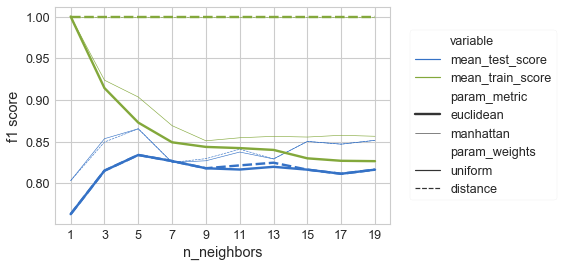

In [14]:
sns.lineplot(x = res.param_n_neighbors, y = res.value, size = res.param_metric, hue = res.variable,
             style = res.param_weights)
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left") # move legend outide of grid
plt.xticks(range(1,20,2))
plt.ylabel('f1 score')
plt.xlabel('n_neighbors');

1. k_neighbors: The 'elbow' where the train and test scores converge appears around k=5-7 <br> 
2. weights: Test scores were hardly affected, but weighting by distance completely overestimated the training score, making 'uniform' a better choice. <br>
3. metric: Manhattan scores are consistently (slightly) higher than euclidean. However the euclidean curves are smooth, while manhattan are somewhat erratic, indicating they could be overfit. <br>
Overall, the parameters selected during training (k=5, weights=uniform, and metric=manhattan) appear reasonable.

The model was refit with the best parameters found during grid search, so can be used predict labels for test data and evaluate performance.

In [15]:
y_pred = model.predict(X_test)

In [16]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.76      0.80        42
           1       0.81      0.88      0.84        49

    accuracy                           0.82        91
   macro avg       0.83      0.82      0.82        91
weighted avg       0.83      0.82      0.82        91



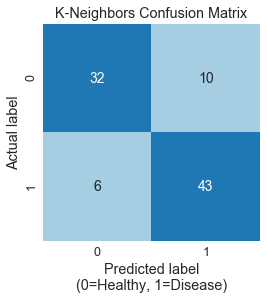

In [17]:
sns.heatmap(metrics.confusion_matrix(y_test, y_pred), cmap=sns.color_palette('Paired', 2),
            annot=True, annot_kws={'size':14}, cbar=False, square=True)
plt.xlabel('Predicted label\n(0=Healthy, 1=Disease)')
plt.ylabel('Actual label')
plt.title('K-Neighbors Confusion Matrix');

Precision and recall are fairly balanced. The model tends to over-predict presence of heart disease (false positives).

## Model 2: Linear Support Vector Classification
As suggested by the scikit-learn guide: [Choosing the right estimator](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html)

In [18]:
# dual=False is preferred when n_samples > n_features
# when dual=False, implementation is not random so do not need to set random_state
clf = LinearSVC(dual=False, verbose=1)

In [19]:
clf.fit(X_train, y_train)

[LibLinear]

LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=1)

In [20]:
c_pred = clf.predict(X_test)

In [21]:
print(metrics.classification_report(y_test, c_pred))

              precision    recall  f1-score   support

           0       0.92      0.79      0.85        42
           1       0.84      0.94      0.88        49

    accuracy                           0.87        91
   macro avg       0.88      0.86      0.87        91
weighted avg       0.87      0.87      0.87        91



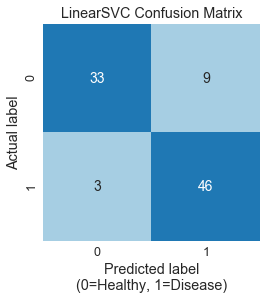

In [22]:
sns.heatmap(metrics.confusion_matrix(y_test, c_pred), cmap=sns.color_palette('Paired', 2),
            annot=True, annot_kws={'size':14}, cbar=False, square=True)
plt.xlabel('Predicted label\n(0=Healthy, 1=Disease)')
plt.ylabel('Actual label')
plt.title('LinearSVC Confusion Matrix');